In [2]:
%pip install numpy
%pip install bs4
%pip install scikit-optimize
%pip install line_profiler
%pip install sklearn
%pip install shap
%pip install SALib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
np.bool = np.bool_
import shap


def shap_feature_importance(X, y):
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_sum = np.abs(shap_values).mean(axis=0)
    shap_importance = pd.DataFrame({'Feature': X.columns, 'SHAP Importance': shap_sum})
    shap_importance = shap_importance.sort_values(by='SHAP Importance', ascending=False)
    return shap_importance

# 2. Random Forest Feature Importance
def random_forest_feature_importance(X, y):
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    rf_importance = pd.DataFrame({'Feature': X.columns, 'RF Importance': model.feature_importances_})
    rf_importance = rf_importance.sort_values(by='RF Importance', ascending=False)
    return rf_importance

# 3. L1 Regularization (Lasso) Feature Importance
def lasso_feature_importance(X, y):
    model = Lasso(alpha=0.00001, max_iter=10000)
    model.fit(X, y)
    lasso_importance = pd.DataFrame({'Feature': X.columns, 'Lasso Coefficient': np.abs(model.coef_)})
    lasso_importance = lasso_importance.sort_values(by='Lasso Coefficient', ascending=False)
    return lasso_importance

# 4. Permutation Feature Importance
def permutation_feature_importance(X, y):
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Permutation Importance': perm_importance.importances_mean})
    perm_importance_df = perm_importance_df.sort_values(by='Permutation Importance', ascending=False)
    return perm_importance_df

# 5. Gradient Boosting Feature Importance
def gradient_boosting_feature_importance(X, y):
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X, y)
    gb_importance = pd.DataFrame({'Feature': X.columns, 'GB Importance': model.feature_importances_})
    gb_importance = gb_importance.sort_values(by='GB Importance', ascending=False)
    return gb_importance

In [7]:
def remove_symbols_from_file(file_path, symbols_to_remove):
    with open(file_path, 'r') as file:
        content = file.read()
    
    for symbol in symbols_to_remove:
        content = content.replace(symbol, '')
    
    return content

file_path = 'optimals.txt'
symbols_to_remove = ['[', ']']
cleaned_content = remove_symbols_from_file(file_path, symbols_to_remove)
print(cleaned_content)

with open(file_path, 'w') as file:
    file.write(cleaned_content)

2, 48, 1181, 29, 831, 93, 6, 43, 20, 24.289581174855307, 4, 288.3591594158186, -1, 1, 999, 1008, -1, -5, 234.7343779256768, 7, 998, 4990, 62.58982459565475, 92, -1, 65, -8, 1001, 998, 0, 8, 28.230809441377023, 100009, 14.485980963283726, -9, 3, 263, 16.157311022755003, 3.448688945577634, 24.555391140089323, -9, 4.324289358035942, 117.0401155731376, 5188.536236962801, 4896.3758861977885, 7, 995, 1.1098892966242446, -7, -1, 44.530012061321884, 1.5583905947023584, -6, 36.93107123530575, 23.104162608755843, 4.588390302646103, 105.7689797618358, 1.776006716165636, 3.9396267593849, 1.3684506434052404, 8.88094644804382, 6.016818106346072, 1.4878208917034408, 14.63421988894579, 1, 120, 8.744771036647476, 0, 4.11784340970618, 27, -2, 4, 0, 14.134034725693226, 5.334565845289627, 3.7061503126310873, 0, 2, 6, -6, 70.9524374827075, 2.610187531691542, 5, 0.785787936056229, -1, 4, 19991, 33.84124517330369, 29, 3.518482961542392, 2095.450352591996, 1.522693477741129, 200, 0, 16, 15, 14.634734648302612

In [8]:
from sklearn import preprocessing

X = pd.read_csv('optimals.txt')
X.columns = [f'feature_{i}' for i in range(X.shape[1])]
y = pd.read_csv('scores.txt')
y.columns = ['score (TPS)']

x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

X.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y.head()

,score (TPS)
0,401.850
1,400.600
2,399.250
3,394.625


In [9]:
df = shap_feature_importance(X, y)
df.head(30)

top_30_features = df['Feature'].head(30).tolist()
top_30_features

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


[0,
 61,
 89,
 88,
 87,
 86,
 85,
 84,
 83,
 82,
 81,
 80,
 79,
 78,
 77,
 76,
 75,
 74,
 73,
 72,
 71,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 90]

In [7]:
df = random_forest_feature_importance(X, y.to_numpy())
df.head(30)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Feature,RF Importance
58,58,0.044336
114,114,0.030425
41,41,0.029956
7,7,0.029738
84,84,0.028820
23,23,0.027173
53,53,0.025007
47,47,0.020744
40,40,0.020408
88,88,0.020332


In [8]:
df = lasso_feature_importance(X, y)
df.head(30)

,Feature,Lasso Coefficient
0,0,6.537061
2,2,2.591183
4,4,1.493673
1,1,1.093908
5,5,0.403856
9,9,0.337281
7,7,0.242856
8,8,0.214362
10,10,0.143019
12,12,0.124528


In [9]:
df = permutation_feature_importance(X, y)
df.head(30)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Feature,Permutation Importance
114,114,0.019399
23,23,0.018594
7,7,0.017209
84,84,0.016880
109,109,0.016710
88,88,0.016681
101,101,0.016531
41,41,0.016187
97,97,0.015349
120,120,0.014712


In [10]:
df = gradient_boosting_feature_importance(X, y)
df.head(30)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


,Feature,GB Importance
20,20,0.181924
17,17,0.136471
71,71,0.110541
96,96,0.089538
0,0,0.087610
5,5,0.062774
110,110,0.047584
36,36,0.038543
97,97,0.031229
79,79,0.025289


In [11]:
from SALib import ProblemSpec

model = RandomForestRegressor()
model.fit(X, y)

problem = {
    'num_vars': X.shape[1],
    'names': X.columns.tolist(),
    'bounds': [[X[col].min(), X[col].max()] for col in X.columns]
}

sp = ProblemSpec(problem)
sp.sample_saltelli(1000)

sp.set_results(model.predict(sp.samples))
sp.analyze_sobol()

sp

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


Samples:
	121 parameters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]
	244000 samples
Outputs:
	1 outputs: ['Y']
	244000 evaluations
Analysis:
           ST   ST_conf
0    0.000000  0.000000
1    0.010390  0.001121
2    0.000405  0.000038
3    0.001096  0.000351
4    0.000232  0.000034
..        ...       ...
116  0.001335  0.000161
117  0.020852  0.001821
118  0.000000  0.000000
119  0.007822  0.000796
120  0.000000  0.000000

[121 rows x 2 columns]
           S1   S1_conf
0    0.000000  0.000000
1    0.005950  0.009092
2   -0.000176  0.0018

In [12]:
sobol_df = pd.DataFrame({
        'Feature': problem['names'],
        'S1': sp.analysis['S1'],
        'ST': sp.analysis['ST']
    }).sort_values(by='ST', ascending=False)

sobol_df.head(30)

,Feature,S1,ST
79,79,0.147611,0.136679
6,6,0.067073,0.101124
33,33,0.089799,0.094784
38,38,0.059405,0.055360
67,67,0.058858,0.050835
85,85,0.045522,0.047547
28,28,0.042578,0.040005
89,89,0.023793,0.032282
46,46,0.032236,0.031603
53,53,0.033593,0.028782


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)

loadings = pd.DataFrame(
        np.abs(pca.components_),
        columns=X.columns
    )

explained_variance = pca.explained_variance_ratio_
weighted_loadings = loadings.multiply(explained_variance, axis=0)
importance_scores = weighted_loadings.sum(axis=0).sort_values(ascending=False)

results = pd.DataFrame({
    'Feature': importance_scores.index,
    'Importance': importance_scores.values
}).reset_index(drop=True)

results.head(30)

,Feature,Importance
0,118,0.086753
1,86,0.086143
2,34,0.085585
3,109,0.083826
4,119,0.082628
5,18,0.082149
6,81,0.081765
7,31,0.081156
8,13,0.080372
9,51,0.079751


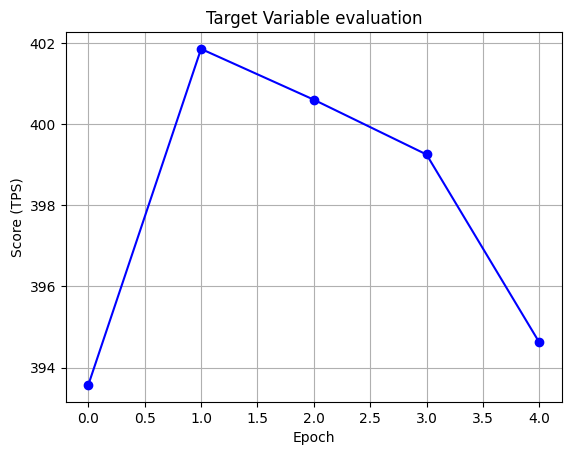

In [15]:
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt

# Plot the scores
# Read array from file
data = np.loadtxt('scores.txt')

# Plot the data
plt.plot(range(len(data)), data, marker='o', linestyle='-', color='b')
# plt.plot(y.index, y['score (TPS)'], marker='o', linestyle='-', color='b')
plt.title('Target Variable evaluation')
plt.xlabel('Epoch')
plt.ylabel('Score (TPS)')
plt.grid(True)
plt.show()